# Beyond Seq2Seq, A deep Dive in a low scale implementation of Google Neural MAchine Translation:

##### Yassin Bahid


## Introduction:

As Seen in my previous report, Seq2Seq offers a great first step in Deepl learning's solution to language translation. However, it stays limitted. Yonghui Wu. et. al 's solution is presented in their 2016 paper: Google's Neural Machine Translation System: Bridging the Gap between Human and Machine Translation. In this paper they offer an end-to-end translation recurrent network. While the original architechture stays expensive, we offer certain modifications to ease the training on smaller machine.

In [27]:
from IPython.display import YouTubeVideo
from torchtext import data
from torchtext.vocab import Vectors
import spacy
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import nltk
# nltk.download('all')
from nltk.tokenize import word_tokenize
from collections import defaultdict
from tqdm import tqdm_notebook
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import time
import os
from pathlib import Path
import sys
import matplotlib.pyplot as plt
import re
import string
import unicodedata
import math
from collections import Counter, defaultdict
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence
import torch.nn.init as init
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Running On...:', device)
# plt.switch_backend('agg')
import matplotlib.ticker as ticker

Running On...: cuda


## 2 - Data:

Instead of using the pytorcg data set, we use the codex of the euroipean parlement speeches: https://www.statmt.org/europarl/v7. French being my secind language, I chose to study the french english translation. I create a data cleaning object in order to prepare data for the training.


### 2.1 - Cleaning Data:



In [2]:
class DataCleaner:
    def __init__(self,filename):
        '''
        filename: path of the data
        '''
        
        self.path = filename
        self.LoadData()
        self.CleanData()
    def LoadData(self):
        file = open(self.path, mode='rt', encoding='utf-8')
        self.RawText = file.read()
        file.close()
        
    def CleanData(self):
        cleanedData = list()
        
        #changing text into sentences
        self.RawSentences = self.RawText.strip().split('\n')
        ## Regex to filter charachters:
        re_filt = re.compile('[^%s]' % re.escape(string.printable))
        
        ## loading function to delete punctuation:
        table = str.maketrans('', '', string.punctuation)
        for line in self.RawSentences:
            ## Normalizing
            cleanline = unicodedata.normalize('NFD', line).encode('ascii', 'ignore').decode('UTF-8')
            ## Tokenizing:
            cleanline = cleanline.split()
            cleanline = [word.lower() for word in cleanline]
            cleanline =  [word.translate(table) for word in cleanline]
            cleanline = [re_filt.sub('', w) for w in cleanline]
            cleanline = [word for word in cleanline if word.isalpha()]
            cleanedData.append(' '.join(cleanline))
        self.CleanedData = cleanedData
    
    '''
    We now add a byte pair encoding
    '''
    
    def AddBytePairEncoding(self):
        ## creating general dictionary
        for sent in self.CleanedData():
            senttokens = [" ".join(word) + " </w>" for word in FrenchData[1].split()]
            sentvocab = Counter(senttokens)  

In [3]:
FrenchData = DataCleaner('data/europarl-v7.fr-en.fr').CleanedData

EnglishData = DataCleaner('data/europarl-v7.fr-en.en').CleanedData

In [4]:
FrenchData[1]

'je declare reprise la session du parlement europeen qui avait ete interrompue le vendredi decembre dernier et je vous renouvelle tous mes vux en esperant que vous avez passe de bonnes vacances'

In [5]:
## Creating Language Class containing codex:

SOS_token = 0
EOS_token = 1

class Language:
    def __init__(self,name):
        '''
        name: name of the language
        '''
        self.name = name
        self.word2index = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.word2count = {}
        self.wordcount = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.wordcount
            self.word2count[word] = 1
            self.index2word[self.wordcount] = word
            self.wordcount += 1
        else:
            self.word2count[word] += 1

            
            
## Creating Language Pairs:

eng_prefixes = ["i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re ", "I don t", "Do you", "I want", "Are you", "I have", "I think",
       "I can t", "I was", "He is", "I m not", "This is", "I just", "I didn t",
       "I am", "I thought", "I know", "Tom is", "I had", "Did you", "Have you",
       "Can you", "He was", "You don t", "I d like", "It was", "You should",
       "Would you", "I like", "It is", "She is", "You can t", "He has",
       "What do", "If you", "I need", "No one", "You are", "You have",
       "I feel", "I really", "Why don t", "I hope", "I will", "We have",
       "You re not", "You re very", "She was", "I love", "You must", "I can"]
class LangPair():
    def __init__(self, lg1, lg2, Lg1list, Lg2list, max_length = 12):
        self.lg1 = Language(lg1)
        self.lg2 = Language(lg2)
        self.max_length = max_length
        self.ReadLang(Lg1list, Lg2list)
        self.CleanPairs()
        self.AddCorpus()
    
    def ReadLang(self, Lg1list, Lg2list):
        self.Pairs = [[Lg1list[i], Lg2list[i]] for i in range(0, len(Lg1list))]
        self.ReversePairs = [[Lg2list[i], Lg1list[i]] for i in range(0, len(Lg1list))]
    def CleanPairs(self):
        self.Pairs = [pair for pair in self.Pairs if len(pair[0].split(' ')) < self.max_length and \
                                                    len(pair[1].split(' ')) < self.max_length and \
                                                            pair[1].startswith(tuple(eng_prefixes))]
    def AddCorpus(self):
        for pair in self.Pairs:
            self.lg1.addSentence(pair[0])
            self.lg2.addSentence(pair[1])
        print("Counted words:")
        print(self.lg1.name, self.lg1.wordcount)
        print(self.lg2.name, self.lg2.wordcount) 

In [6]:
FREN_pairs = LangPair('fr','en', FrenchData, EnglishData)

Counted words:
fr 7009
en 5336


## 3 - Model:

The Original RNN consiste of 8 LSTM layers for the encoder, followed with the The Bahdanau Attention function, and then an 8 layer decoder. Each layer is an LSTM layer. The first layer is bidirectional. 
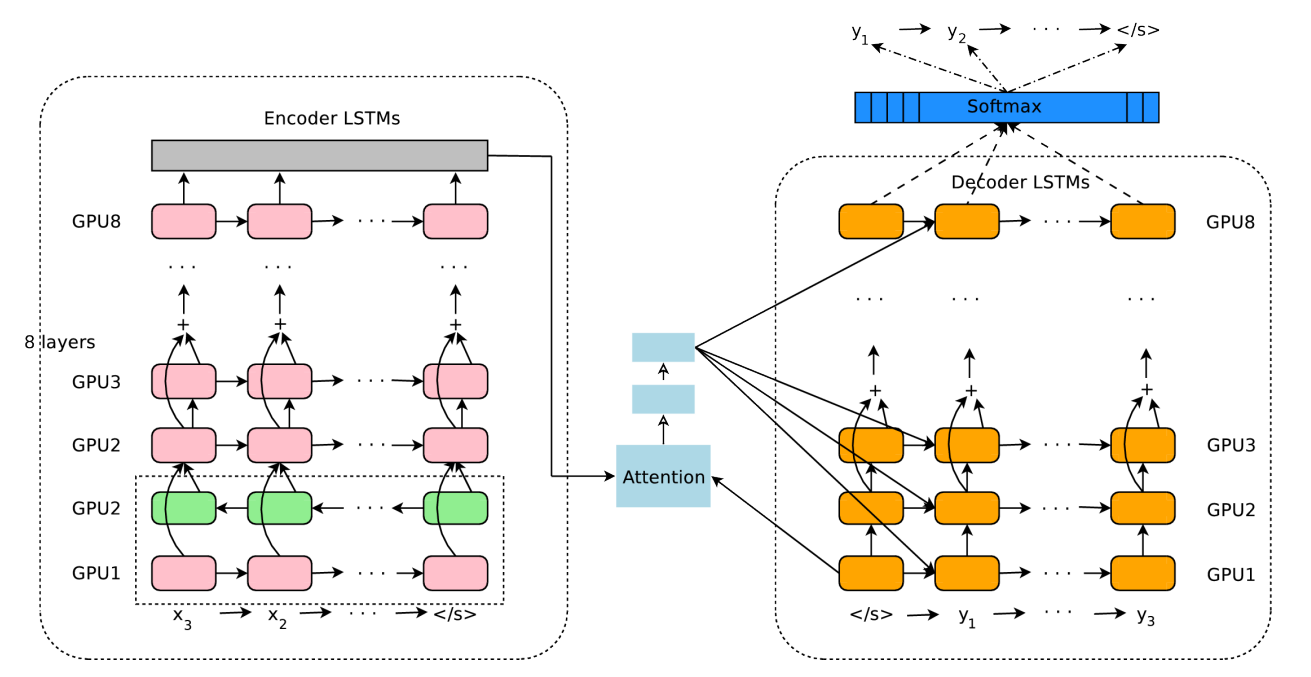

This architechture stays very expensive to run. We halve the number of layers. Our encoder will have 4 layers, with the first layert being bidirectional. We still use the Bahdanau Attention before the 4 layer decoder.

### 3.1 - GRU VS LSTM:

While the LSTM layers do a great job in the original paper, we found that given the small size of our data set LSTM tend to perform poorly. Upon search, we found that a GRU layer that offer performance on par with LSTM but is more computationally inexpensive. It is also more adequate for smaller datasets such as ours. A more in depth explanation is offered in the following video:

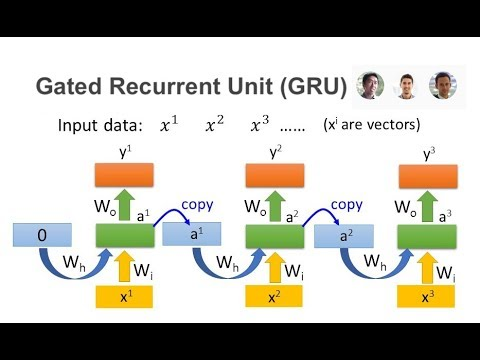

In [29]:
YouTubeVideo('pYRIOGTPRPU', width=800, height=300)

In [7]:
## Initializing the maximum sentence length:
MAX_LENGTH = 12

In [8]:
class GNMTEncoder(nn.Module):
    def __init__(self, 
                 input_size, 
                 hidden_size=1024, 
                 num_layers=4, 
                 dropout=0.2,
                 batch_first=False, 
                 embedder=None, 
                 init_weight=0.1):
        super(GNMTEncoder, self).__init__()
        
        
        self.embed = nn.Embedding(input_size, hidden_size, padding_idx=0)
        
        self.hidden_size = hidden_size
        self.drop = nn.Dropout(p=dropout)
        
        self.layers = nn.ModuleList()
        
        ## Adding 1st lstm bidiractional layer:
        self.layers.append(nn.GRU(hidden_size, hidden_size, num_layers=1, bias=True, bidirectional= True, batch_first=batch_first))
        ## Adding 2nd lstm layer:
        self.layers.append(nn.GRU((2 * hidden_size), hidden_size, num_layers=1, bias=True,batch_first=batch_first))
        ##Adding the leftover layers: num_layers - 2:
        for i in range(num_layers-2):
            self.layers.append(nn.GRU(hidden_size, hidden_size, num_layers=1, bias=True, batch_first=batch_first))
        ## initializing the lstm layers:

        self.gru = nn.GRU(hidden_size, hidden_size)
    def forward(self, inputs, hidden):
        '''
        input: tensor generated from vocabulary
        length: vect with sequence length
        '''
        x = self.embed(inputs).view(1, 1, -1)
        x= self.drop(x)
        x, _ = self.layers[0](x)
        x= self.drop(x)
        x, _ = self.layers[1](x)
        for i in range(2, len(self.layers)-1):
            residual = x
            x= self.drop(x)
            x, _ = self.layers[i](x)
            x = x + residual
        x = self.drop(x)
        output, hidden = self.layers[-1](x)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
    

In [9]:
class GNMTDecoder(nn.Module):
    def __init__(self,
                 output_size,
                 hidden_size = 1024,
                 dropout_p=0.1, 
                 num_layers = 4,
                 max_length=MAX_LENGTH,
                 batch_first=False,):
        super(GNMTDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.drop = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
             self.layers.append(nn.GRU(hidden_size, hidden_size, num_layers=1, bias=True, batch_first=batch_first))
        self.gru = nn.GRU(hidden_size, hidden_size)
    def forward(self, inputs, hidden, encoder_outputs):
        
        embedded = self.embedding(inputs).view(1, 1, -1)
        embedded = self.drop(embedded)
        ## Applying Bahdanau Attention
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        
        x = torch.cat((embedded[0], attn_applied[0]), 1)
        x = self.attn_combine(x).unsqueeze(0)
        x, _ = self.layers[0](x)
        x= self.drop(x)
        x, _ = self.layers[1](x)
        for l in self.layers[2:]:
            x,_ = l(x)
            x = self.drop(x)
            x = torch.cat((x[0], attn_applied[0]), 1)
            x = self.attn_combine(x).unsqueeze(0)

        output = F.relu(x)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


# Trainig


In [10]:
def train(input_tensor, 
          target_tensor,
          encoder, 
          decoder, 
          encoder_optimizer, 
          decoder_optimizer, 
          criterion,
          input_lang,
          output_lang,
          teacher_forcing_ratio,
          max_length=12):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    if random.random() < teacher_forcing_ratio:

        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


def tensorsFromPair(pair, input_lang, output_lang):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [11]:
def trainIters(encoder, 
               decoder, 
               n_iters,
               input_lang,
               output_lang,
               pairs,
               teacher_forcing_ratio,
               print_every=1000,
               plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adagrad(encoder.parameters())
    decoder_optimizer = optim.Adagrad(decoder.parameters())
    training_pairs = [tensorsFromPair(random.choice(pairs), input_lang, output_lang)
                      for i in range(n_iters)]
    criterion = nn.CrossEntropyLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion,input_lang, output_lang, teacher_forcing_ratio)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    # showPlot(plot_losses)
    return plot_losses

## Training model

In [12]:
teacher_forcing_ratio = 0.5
hidden_size = 256
encoder = GNMTEncoder(FREN_pairs.lg1.wordcount, hidden_size = hidden_size).to(device)
attn_decoder = GNMTDecoder(FREN_pairs.lg2.wordcount, hidden_size = hidden_size, dropout_p=0.1).to(device)

losses = trainIters(encoder, attn_decoder, 100000, FREN_pairs.lg1, FREN_pairs.lg2, FREN_pairs.Pairs, teacher_forcing_ratio, print_every=5000)

3m 33s (- 67m 30s) (5000 5%) 3.9523
6m 47s (- 61m 6s) (10000 10%) 3.6582
10m 8s (- 57m 29s) (15000 15%) 3.4922
13m 24s (- 53m 39s) (20000 20%) 3.4440
16m 40s (- 50m 2s) (25000 25%) 3.3443
19m 56s (- 46m 32s) (30000 30%) 3.2655
23m 13s (- 43m 7s) (35000 35%) 3.2035
26m 32s (- 39m 48s) (40000 40%) 3.1274
29m 51s (- 36m 29s) (45000 45%) 3.0831
33m 9s (- 33m 9s) (50000 50%) 3.0377
36m 27s (- 29m 49s) (55000 55%) 2.9752
39m 40s (- 26m 26s) (60000 60%) 2.9260
42m 55s (- 23m 6s) (65000 65%) 2.8679
46m 13s (- 19m 48s) (70000 70%) 2.8539
49m 35s (- 16m 31s) (75000 75%) 2.8351
52m 57s (- 13m 14s) (80000 80%) 2.7930
56m 20s (- 9m 56s) (85000 85%) 2.7300
59m 41s (- 6m 37s) (90000 90%) 2.7166
62m 58s (- 3m 18s) (95000 95%) 2.6848
66m 17s (- 0m 0s) (100000 100%) 2.6548


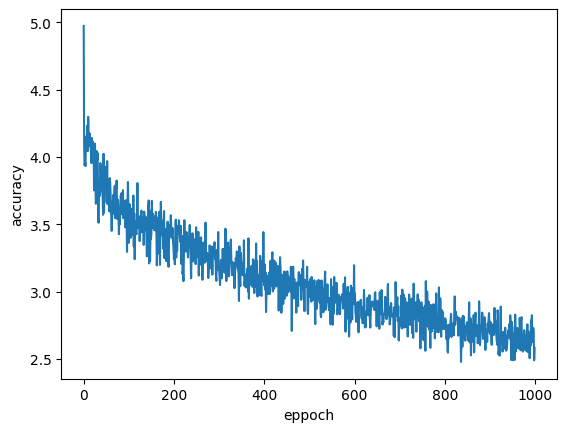

In [38]:
plt.plot([i for i in range(0,len(losses))], losses)
plt.xlabel('eppoch')
plt.ylabel('accuracy')
plt.show()

## Translator:



In [14]:
def evaluate(encoder, decoder, sentence, max_length=12):
    with torch.no_grad():
        input_tensor = tensorFromSentence(FREN_pairs.lg1, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(FREN_pairs.lg2.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return ' '.join(decoded_words)

In [36]:
sentences = ["je suis heureux",
            "je suis en faveur",
            "je suis triste"]

for se in sentences:
    print('fr:', se )
    out_se =  evaluate(encoder, attn_decoder, se)
    print('en:', out_se)

fr: je suis heureux
en: i am pleased <EOS>
fr: je suis en faveur
en: i am in favour of <EOS>
fr: je suis triste
en: i am very <EOS>


#### 3.4.2 Final Observations:

The model does well with simple sentences. It also does very well with slightly more complicated compered to the simple seqtoseq model. When confronted with more complicated words or rare words. There are two main explanation: The first is that the data set is too small. The second is the absence of the total french vocabulary in it. The dataset consisting of EU speeches, one can imagine that the vocabulary used is very restricted due to immediate translation needed and the 
